<a href="https://colab.research.google.com/github/maritnorli/IFCB_CNN_Classify/blob/main/model_1_CNN_effnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Connect to cuda and Mount Drive manually in Colab!!!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Import the colab libraries and set up paths
from google.colab import drive
import os

## copy helper, train, etc scripts from drive to colab
import shutil
# Specify the path to your "going_modular" folder in Google Drive
drive_path = "/content/drive/MyDrive/IFCB/going_modular"


# List files in the "going_modular" folder
files = os.listdir(drive_path)

# Copy each file individually to the /content directory
for file in files:
    src = os.path.join(drive_path, file)
    dst = os.path.join("/content", file)
    try:
        shutil.copy(src, dst)
    except Exception as e:
        print(f"Failed to copy {file}: {e}")

# wait a minute or so before it pops up

In [4]:
from pathlib import Path

# Set data paths
data_path = Path("/content/drive/MyDrive/IFCB/data/")
image_path = Path("/content/drive/MyDrive/IFCB/data/IFCB_test_train")

# Setup Dirs
train_dir = image_path / "Train_small"
test_dir = image_path / "Test_small"


In [5]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Now try importing modules directly from the copied drive files
try:
    import data_setup
    import engine

except ModuleNotFoundError as e:
    print(f"Failed to import modules: {e}")


[INFO] Couldn't find torchinfo... installing it.


In [6]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
#Create transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [8]:
# Create training and testing dataloaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x783ffdf06170>,
 ['Achnathes_like_129',
  'Air_bubbles_149',
  'Akashiwo_sanguinea_057',
  'Alexandrium_pseudogonyaulax_060',
  'Amphidinium_like_015',
  'Apedinella_radians_031',
  'Asterionellopsis_glacialis_034',
  'Beads_148',
  'Centrales_sideview',
  'Centrales_topview',
  'Cerataulina_pelagica_036',
  'Chaetoceroa_affinis_037',
  'Chaetoceros_contortus_128',
  'Chaetoceros_curvicetus_like_151',
  'Chaetoceros_danicus_039',
  'Chaetoceros_debilis_like_152',
  'Chaetoceros_decipiens_118',
  'Chaetoceros_diadema_136',
  'Chaetoceros_didymus_133',
  'Chaetoceros_phaeoceros_038',
  'Chaetoceros_similis_161',
  'Chaetoceros_socialis_gelidus_040',
  'Chaetoceros_tenuissimus_like_041',
  'Cocconeis_like_124',
  'Cochlodinium_like_150',
  'Coscinodiscus_spp_005',
  'Cryptophyceae_022',
  'Cylindrotheca_closterium_042',
  'Dactyliosolen_fragilissimus_007',
  'Debris_010',
  'Detonula_Lauderia_like_115',
  'Dictyocha_fibula_014',
  'Dinophysis_a

In [9]:
# Make a model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

#freeze base layers
for param in model_1.features.parameters():
  param.requires_grad = False

#Change classification head
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    #Here: we want to keep the tensor size of infeatures in efficientnet as 1280,
    #but change the length of out features from 1000 to 3 (class outputs)
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)
model_1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 73.7MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
#Create a loss and optimizer
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [11]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 4.4055 | train_acc: 0.0341 | test_loss: 4.1919 | test_acc: 0.1029
Epoch: 2 | train_loss: 3.6262 | train_acc: 0.4006 | test_loss: 3.8598 | test_acc: 0.2151
Epoch: 3 | train_loss: 2.9664 | train_acc: 0.7557 | test_loss: 3.5403 | test_acc: 0.3768
Epoch: 4 | train_loss: 2.4632 | train_acc: 0.8352 | test_loss: 3.1956 | test_acc: 0.5478
Epoch: 5 | train_loss: 2.0214 | train_acc: 0.8807 | test_loss: 2.8488 | test_acc: 0.5778
Epoch: 6 | train_loss: 1.7063 | train_acc: 0.8665 | test_loss: 2.4614 | test_acc: 0.5607
Epoch: 7 | train_loss: 1.3982 | train_acc: 0.9631 | test_loss: 2.1182 | test_acc: 0.6219
Epoch: 8 | train_loss: 1.2061 | train_acc: 0.9119 | test_loss: 1.9490 | test_acc: 0.6324
Epoch: 9 | train_loss: 1.0279 | train_acc: 0.9716 | test_loss: 1.8529 | test_acc: 0.6612
Epoch: 10 | train_loss: 0.9187 | train_acc: 0.9574 | test_loss: 1.7578 | test_acc: 0.6520
[INFO] Total training time: 236.026 seconds


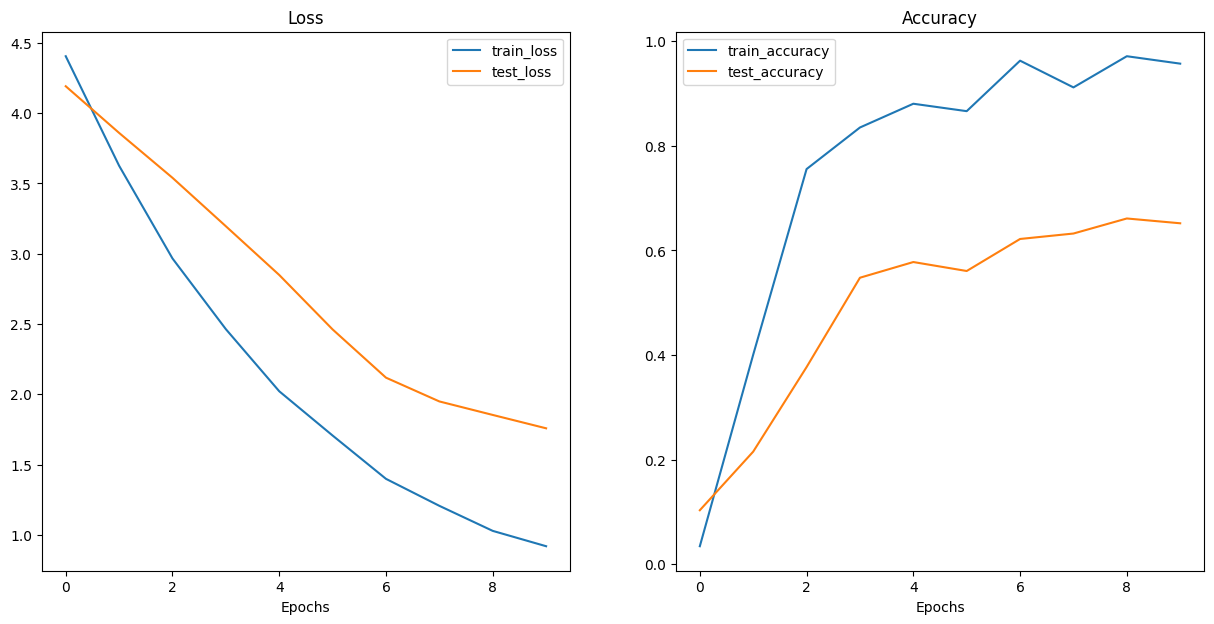

In [12]:
# Plot the loss curves
from helper_functions import plot_loss_curves
#Plot the loss urves of model_1
plot_loss_curves(model_1_results)

Note to self: Tried on the full classifier and runtime was not great for testing. Using classes of 5 images (4 train, 1 test) was ok. Still taking some time before it starts training in epochs, but at least its possible to do it with all the classes. Max number of images is very low and likely contributes to bad accuracy in addition to having to test more layers of transforms.
